## Decision Tree VS Random Forest; Predict survival on the Titanic

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, r2_score, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.tree import plot_tree

In [187]:
train = pd.read_csv("train.csv") # load training data
test = pd.read_csv("test.csv") # load testing data
genderSubmissionData = pd.read_csv("gender_submission.csv") # load testing ground truth file
train.head() # observe structure of data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [188]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Describe the data to determine the preprocessing that needs to be done.
As we can observe, there are missing counts of values for some rows such as the age feature. We can also observe
the ranges and other statistics of each feature.

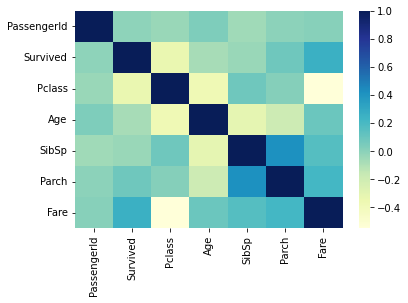

In [189]:
sns.heatmap(train.corr(), cmap = "YlGnBu")
plt.show()

Use this heatmap to identify important correlated features with survival in training set. Negative and positive correlations are of importance and a correlation of 0 is not significant.

In [190]:
train.head() # Here we can further think about data preprocessing as we can observe some non numeric values for categorical 
# features such as sex, name, and so on.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [191]:
train.info() # Observe here that cabin, age, and embarked have some missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [192]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We have established that there are missing values, categorical features, noisy and unnecessary information like name and ticket, we can begin cleaning the data to obtain a much more robust dataset to feed the models.

In [193]:
finalPredictions = pd.DataFrame(test['PassengerId'])
def clean(data):
    data['Deck'] = data['Cabin'].str.get(0) # some useful information could be gained from using the cabin feature. We can notice that there is a letter as a prefix 
# for the cabin, which could indicate the deck level of the ship. We can extract this and create a new deck feature.
    le = LabelEncoder()
    for col in ['Sex', 'Name', 'Ticket', 'Cabin', 'Embarked', 'Deck']:
        data[col] = le.fit_transform(data[col])
    imputer = KNNImputer(n_neighbors = 5)
    cols = ['Age', 'Cabin', 'Embarked', 'Deck', 'Fare']
    for col in cols:
        data[col] = imputer.fit_transform(data[[col]])
        data[col] = data[col].astype(int)
    data = data.drop(["Ticket", "Cabin", "Name", "PassengerId", "SibSp", "Parch"], axis = 1)
    return data

train = clean(train)
test = clean(test)
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Deck
0,0,3,1,22,7,2,8
1,1,1,0,38,71,0,2
2,1,3,0,26,7,2,8
3,1,1,0,35,53,2,2
4,0,3,1,35,8,2,8


We do not need the name, ticket, cabin, ID, siblings/spouse, and parent/children information because those features have very little correlation with survival. The only features that would have any correlation with survival would be what deck an individual was on (as obtained from the first character in the cabin designation), the individuals gender, age, ticket class (Pclass), and the amount of money spend on the ticket (fare). Therefore, we can drop the unnecessary information and keep the correlative features.

In [194]:
test.isnull().sum() # check if there are any more missing feature values for the testing set 

Pclass      0
Sex         0
Age         0
Fare        0
Embarked    0
Deck        0
dtype: int64

In [195]:
train.isnull().sum() # check if there are any more missing feature values for the testing set

Survived    0
Pclass      0
Sex         0
Age         0
Fare        0
Embarked    0
Deck        0
dtype: int64

In [196]:
y_train = train.Survived # load the survival ground truth for training
X_train = train.drop(['Survived'], axis = 1) # prepare the training set to be fed into the model

In [197]:
y_test = genderSubmissionData.Survived # load the survival ground truth for testing
X_test = test

In [198]:
sc = StandardScaler() # standardize the training and testing data to be on similar scales.
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

Decision Tree Root Mean Square Error :  0.4347357994357087


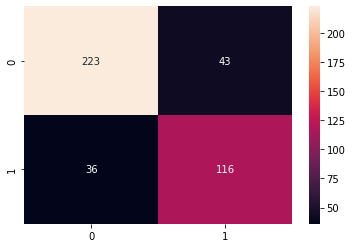

In [199]:
modelTree = DecisionTreeClassifier() # fit the decision tree
modeltree = modelTree.fit(X_train, y_train)

modelForest = RandomForestClassifier() # fit the random forest
modelForest = modelForest.fit(X_train, y_train)

y_predTree = modelTree.predict(X_test) # predict the testing data using the decision tree
y_predForest = modelForest.predict(X_test) # predict the testing data using the random forest

treeError = np.sqrt(mean_squared_error(y_test, y_predTree)) # obtain the error for the decision tree
forestError = np.sqrt(mean_squared_error(y_test, y_predForest)) # obtain the error for the random forest

print('Decision Tree Root Mean Square Error : ', treeError)
cMatrixTree = confusion_matrix(y_test, y_predTree)
tree = sns.heatmap(cMatrixTree, annot = True, fmt = 'd') # create confusion matrix to observe true positive, false positive, 
# true negative, and false negative metrics for the decision tree.

Random Forest Root Mean Square Error :  0.39129279043561477


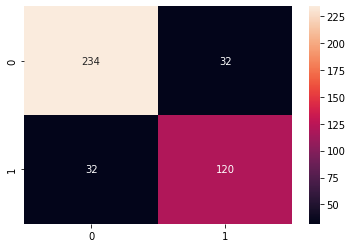

In [200]:
print('Random Forest Root Mean Square Error : ', forestError)
cMatrixForest = confusion_matrix(y_test, y_predForest)
forest = sns.heatmap(cMatrixForest, annot = True, fmt = 'd') # create confusion matrix to observe true positive, false positive, 
# true negative, and false negative metrics for the random forest.

In [201]:
params = {'max_depth': [2,3,4,5,10,20], 'min_samples_split': [2,5,10,20,50,100]}

model_params = GridSearchCV(modelTree, params, cv = 10, n_jobs = -1) # perform grid search to loop through predefined 
# hyperparameters and select the best hyperparameters to fit the models on the training set.
model_params = GridSearchCV(modelForest, params, cv = 10, n_jobs = -1)

model_params = model_params.fit(X_train, y_train)
model_params.best_params_

{'max_depth': 20, 'min_samples_split': 5}

Decision Tree RMSE :  0.45883146774112354


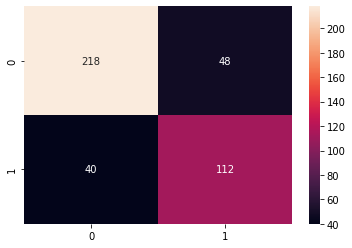

In [202]:
tuned_modelTree = DecisionTreeClassifier(**model_params.best_params_) # fit a new tuned version of each model with the best 
# parameters to improve accuracy and efficiency.
tuned_modelTree.fit(X_train, y_train)

tuned_modelForest = RandomForestClassifier(**model_params.best_params_)
tuned_modelForest.fit(X_train, y_train)

y_predTree = tuned_modelTree.predict(X_test) # test and verify the robustness of the tuned models
y_predForest = tuned_modelForest.predict(X_test)

tuned_treeError = np.sqrt(mean_squared_error(y_test, y_predTree))
tuned_forestError = np.sqrt(mean_squared_error(y_test, y_predForest))

print('Decision Tree RMSE : ',tuned_treeError)
tuned_cMatrixTree = confusion_matrix(y_test, y_predTree)
sns.heatmap(tuned_cMatrixTree, annot = True, fmt = 'd');

Random Forest RMSE :  0.37249963873974967


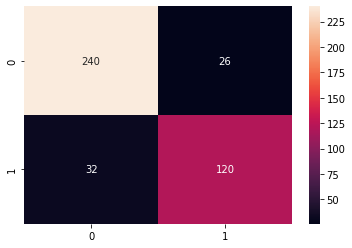

In [203]:
print('Random Forest RMSE : ',tuned_forestError)
tuned_cMatrixForest = confusion_matrix(y_test, y_predForest)
sns.heatmap(tuned_cMatrixForest, annot = True, fmt = 'd');

In [204]:
print("Decision Tree: "+ classification_report(y_test, y_predTree))
print("Random Forest: " + classification_report(y_test, y_predForest))
cv = KFold(n_splits = 5, random_state = 1, shuffle = True) # apply the five-fold cross validation of the models to the
# Titanic training data to extract the average classification accuracy.
print("Decision Tree average five-fold cross validation accuracy:", cross_val_score(DecisionTreeClassifier(), X_train, y_train, scoring = 'accuracy', cv = cv).mean())
print("Random Forest average five-fold cross validation accuracy:", cross_val_score(RandomForestClassifier(), X_train, y_train, scoring = 'accuracy', cv = cv).mean())

Decision Tree:               precision    recall  f1-score   support

           0       0.84      0.82      0.83       266
           1       0.70      0.74      0.72       152

    accuracy                           0.79       418
   macro avg       0.77      0.78      0.78       418
weighted avg       0.79      0.79      0.79       418

Random Forest:               precision    recall  f1-score   support

           0       0.88      0.90      0.89       266
           1       0.82      0.79      0.81       152

    accuracy                           0.86       418
   macro avg       0.85      0.85      0.85       418
weighted avg       0.86      0.86      0.86       418

Decision Tree average five-fold cross validation accuracy: 0.7935157868307073
Random Forest average five-fold cross validation accuracy: 0.8193584834599209


As we can observe, the random forest algorithm is better suited for the task of determining survivors from the testing set.

Now we can return a file with passenger IDs and corresponding survival predictions


In [209]:
finalPredictions['Survived'] = y_predForest
finalPredictions['Survived'] = finalPredictions['Survived'].replace({0:'No', 1:'Yes'})
finalPredictions.to_csv("survivalPredictions.csv", index = False)

In [210]:
finalPredictions

,PassengerId,Survived
0,892,No
1,893,No
2,894,No
3,895,No
4,896,No
...,...,...
413,1305,No
414,1306,Yes
415,1307,No
416,1308,No
